# Доверительные интервалы для оценки среднего

In [1]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import linear_model, metrics, datasets

import numpy as np

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Генерация данных

In [3]:
blobs = datasets.make_blobs(300, centers=2, cluster_std=6, random_state=1)

In [4]:
blobs[0][:3]

array([[-16.12902817,   0.81382089],
       [ -5.89370453,  -6.07380844],
       [ -8.97802629,  19.10270176]])

In [5]:
blobs[1][:3]

array([1, 1, 0])

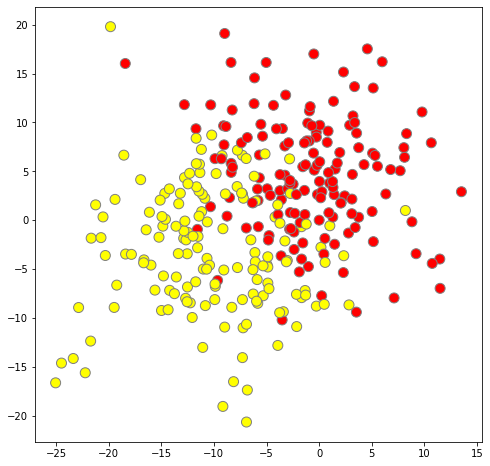

In [6]:
pylab.figure(figsize(8, 8))
pylab.scatter([x[0] for x in blobs[0]], 
              [x[1] for x in blobs[0]], 
              c=blobs[1],
              cmap='autumn',
              s=100,
              edgecolors='gray'
             )

# Сравнение линейных моделей

## Точечная оценка

In [7]:
train_data, test_data, train_labels, test_labels = train_test_split(blobs[0], 
                                                                    blobs[1],
                                                                    test_size=15, 
                                                                    random_state=1)

In [8]:
train_data[0], train_labels[0]

(array([-2.32224206,  0.70231749]), 0)

In [9]:
test_data[0], test_labels[0]

(array([-15.21776184,  -1.73820573]), 1)

<br>

In [10]:
ridge_model = linear_model.RidgeClassifier(random_state=0)

In [11]:
ridge_model.fit(train_data, train_labels)

RidgeClassifier(random_state=0)

In [12]:
metrics.roc_auc_score(test_labels, ridge_model.predict(test_data))

0.8888888888888888

<br>

In [13]:
sgd_model = linear_model.SGDClassifier(random_state=1)

In [14]:
sgd_model.fit(train_data, train_labels)

SGDClassifier(random_state=1)

In [15]:
metrics.roc_auc_score(test_labels, sgd_model.predict(test_data))

0.8888888888888888

## Оценка среднего
Сравним выборочное среднее, многократно извлекая выборки

In [16]:
ridge_auc_scores = cross_val_score(estimator=linear_model.RidgeClassifier(),
                                   X=blobs[0],
                                   y=blobs[1],
                                   scoring='roc_auc',
                                   cv=20
                                  )

In [17]:
ridge_auc_scores

array([1.        , 0.89285714, 0.92857143, 0.89285714, 0.98214286,
       1.        , 0.73214286, 1.        , 0.92857143, 1.        ,
       0.85714286, 0.96428571, 0.91071429, 0.96428571, 0.98214286,
       1.        , 0.82142857, 0.98214286, 0.98214286, 0.91071429])

<br>

In [18]:
sgd_auc_scores = cross_val_score(estimator=linear_model.SGDClassifier(),
                                   X=blobs[0],
                                   y=blobs[1],
                                   scoring='roc_auc',
                                   cv=20
                                  )

In [19]:
sgd_auc_scores

array([0.58928571, 0.91071429, 0.83928571, 0.78571429, 1.        ,
       0.98214286, 0.75      , 1.        , 0.89285714, 0.92857143,
       0.75      , 0.96428571, 0.92857143, 0.96428571, 0.98214286,
       0.98214286, 0.80357143, 1.        , 1.        , 0.91071429])

## Точечная оценка среднего

In [20]:
ridge_mean = ridge_auc_scores.mean()
ridge_std = ridge_auc_scores.std(ddof=1)

In [21]:
print(f"Ridge model AUC: mean {ridge_mean:.3f}, std {ridge_std:.3f}")

Ridge model AUC: mean 0.937, std 0.071


<br>

In [22]:
sgd_mean = sgd_auc_scores.mean()
sgd_std = sgd_auc_scores.std(ddof=1)

In [23]:
print(f"SGD model AUC: mean {sgd_mean:.3f}, std {sgd_std:.3f}")

SGD model AUC: mean 0.898, std 0.112


## Интервальная оценка среднего

In [24]:
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic

### z-интервал

Допустим, нам откуда-то известно, что дисперсия auc_scores $\sigma^2=0.25$. Построим доверительные интервалы для средних вида $$\bar{X}_n \pm z_{1-\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}$$

In [25]:
ridge_z_confint_l, ridge_z_confint_u = _zconfint_generic(
                                        mean=ridge_mean,
                                        std_mean=sqrt(0.25 / len(ridge_auc_scores)),
                                        alpha=0.05, 
                                        alternative='two-sided'
                                    )

In [26]:
print(f"Ridge model mean auc 95%% confidence interval ({ridge_z_confint_l}, {ridge_z_confint_u})")

Ridge model mean auc 95%% confidence interval (0.7174765077129974, 1.155737778001288)


<br>

In [27]:
sgd_z_confint_l, sgd_z_confint_u = _zconfint_generic(
                                    mean=sgd_mean,
                                    std_mean=sqrt(0.25 / len(sgd_auc_scores)),
                                    alpha=0.05, 
                                    alternative='two-sided'
                                )

In [28]:
print(f"Ridge model mean auc 95%% confidence interval ({sgd_z_confint_l}, {sgd_z_confint_u})")

Ridge model mean auc 95%% confidence interval (0.6790836505701403, 1.1173449208584312)


Интервал для Ridge сдвинут правее, что соответствует нашему предположению, что эта модель получилась точнее.   
Степень доверия у этой оценки не очень большая, так как получился слишком большой интервал, и дисперсия на самом деле у нас не известна.

### t-интервал

Вместо гипотетической теоретической дисперсии $\sigma^2$, которую мы на самом деле в данном случае не знаем, используем выборочные дисперсии, и построим доверительные интервалы вида $$\bar{X}_n \pm t_{1-\frac{\alpha}{2}} \frac{S}{\sqrt{n}}$$

In [29]:
ridge_mean_std = ridge_std / sqrt(len(ridge_auc_scores))
sgd_mean_std = sgd_std / sqrt(len(sgd_auc_scores))

In [30]:
ridge_t_confint_l, ridge_t_confint_u = _tconfint_generic(
                                        mean=ridge_mean,
                                        std_mean=ridge_mean_std,
                                        dof=len(ridge_auc_scores) - 1,
                                        alpha=0.05, 
                                        alternative='two-sided'
                                    )

In [31]:
print(f"Ridge model mean auc 95%% confidence interval ({ridge_t_confint_l}, {ridge_t_confint_u})")

Ridge model mean auc 95%% confidence interval (0.903235324375978, 0.9699789613383075)


In [32]:
sgd_t_confint_l, sgd_t_confint_u = _tconfint_generic(
                                        mean=sgd_mean,
                                        std_mean=sgd_mean_std,
                                        dof=len(sgd_auc_scores) - 1,
                                        alpha=0.05, 
                                        alternative='two-sided'
                                    )

In [33]:
print(f"SGD model mean auc 95%% confidence interval ({sgd_t_confint_l}, {sgd_t_confint_u})")

SGD model mean auc 95%% confidence interval (0.8458395292456724, 0.9505890421828991)
